<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/Chap4_CNN(05)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **05. 개/고양이 분류**
- 데이터셋을 배치 단위의 여러 부분으로 나누고 반복 객체(iterator)를 통해 각 배치를 한 개씩 모델에 입력하여 훈련
- ImageDataGenerator 함수 지원 

## **5-1. 분석 준비**

### 5-1-1. 데이터셋 다운로드
- https://www.kaggle.com/datasets/tongpython/cat-and-dog 
- zip 파일명을 cat-and-dog.zip 으로 변경
- 구글 드라이브에 'dataset' 으로 새 폴더 만들고 이 폴더에 zip 파일 업로드

### 5-1-2. 라이브러리 불러오기

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

### 5-1-3. 구글 드라이브 마운트

In [ ]:
# 구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 5-1-4. 압축 파일 해제

In [ ]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/" 
source_filename = drive_path + "dataset/cat-and-dog.zip"   

# 저장할 경로 
extract_folder = "dataset/"   # 코랩 환경에 임시 저장 

# 압축 해제 
import shutil
shutil.unpack_archive(source_filename, extract_folder) 

In [ ]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir = extract_folder + "archive/training_set/training_set"
valid_dir = extract_folder + "archive/test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/archive/training_set/training_set
dataset/archive/test_set/test_set


## **5-2. 모델 학습**

### 5-2-1. ImageDataGenerator
- ImageDataGenerator 클래스 함수를 실행하고 rescale 옵션을 지정해 이미지 각 픽셀의 값을 0~1 범위로 정규화

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

### 5-2-2. flow_from_directory 함수
- ImageDataGenerator 객체에 flow_from_directory 함수를 적용하면, 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋을 처리
- batch_size=32 -> 배치를 구성하는 이미지 개수
- target_size=(224, 224) -> 저장될 이미지의 (세로,가로) 픽셀 사이즈
- classes=['cats','dogs'] -> 클래스 레이블(실제 이미지가 들어있는 하위 폴더 이름)
- class_mode = 'binary' -> 이진 분류 문제
- 훈련 셋, 검증 셋 모두 동일한 방식으로 제너레이터 객체 생성

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen = image_gen.flow_from_directory(train_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,                                          
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


- 1개의 배치를 선택해 배치 안에 들어 있는 32개의 이미지를 정답 클래스 레이블과 함께 출력

In [ ]:
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


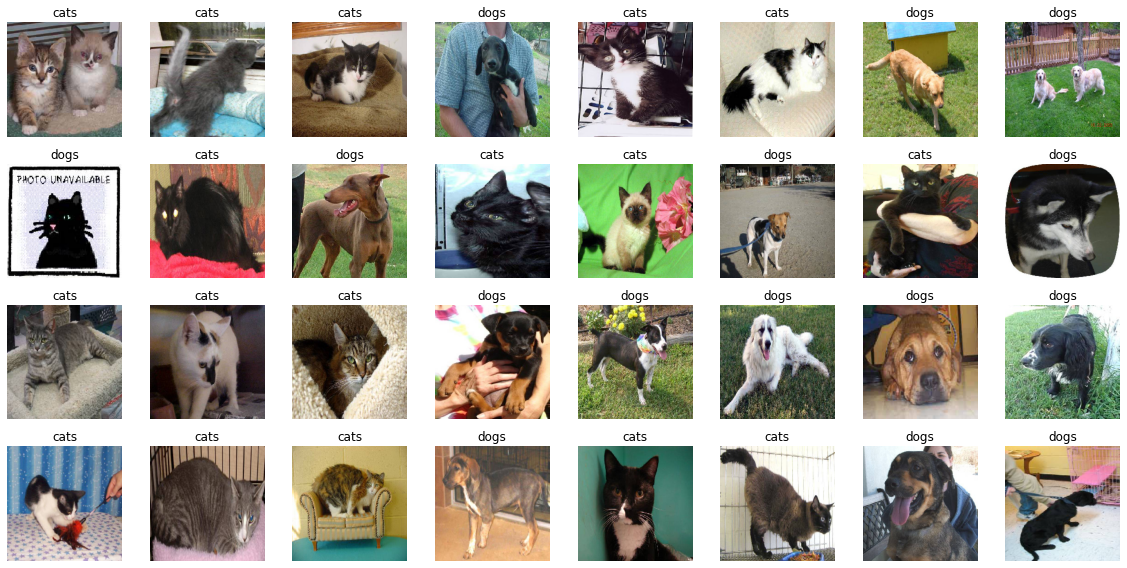

In [ ]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis("off")

plt.tight_layout()
plt.show()

### 5-2-3. 모델 훈련
- 이진 분류 모델 정의
- '배치 정규화-합성곱-풀링'으로 구성된 단위블럭을 3개 반복하여 이미지로부터 다양한 피처를 추출하고, 최종 분류기로는 Dense 레이어 사용
- 최종 출력 레이어는 노드 1개를 갖고 활성화 함수로는 'sigmoid' 적용

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

- 훈련 셋에 대한 정확도는 89%, 검증 셋에 대한 정확도는 76% 수준으로 과대적합 발생

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 42s 155ms/step - loss: 2.3762 - accuracy: 0.5743 - val_loss: 0.6618 - val_accuracy: 0.6303
Epoch 2/20
251/251 [==============================] - 40s 160ms/step - loss: 0.6394 - accuracy: 0.6274 - val_loss: 0.6435 - val_accuracy: 0.6337
Epoch 3/20
251/251 [==============================] - 39s 153ms/step - loss: 0.6072 - accuracy: 0.6537 - val_loss: 0.5836 - val_accuracy: 0.7029
Epoch 4/20
251/251 [==============================] - 39s 155ms/step - loss: 0.5840 - accuracy: 0.6798 - val_loss: 0.5545 - val_accuracy: 0.7093
Epoch 5/20
251/251 [==============================] - 38s 152ms/step - loss: 0.5643 - accuracy: 0.6874 - val_loss: 0.5610 - val_accuracy: 0.6940
Epoch 6/20
251/251 [==============================] - 38s 150ms/step - loss: 0.5443 - accuracy: 0.6996 - val_loss: 0.5341 - val_accuracy: 0.7257
Epoch 7/20
251/251 [==============================] - 40s 159ms/step - loss: 0.5167 - accuracy: 0.7284 - val_loss: 0.5229 - val_accuracy: 0.7

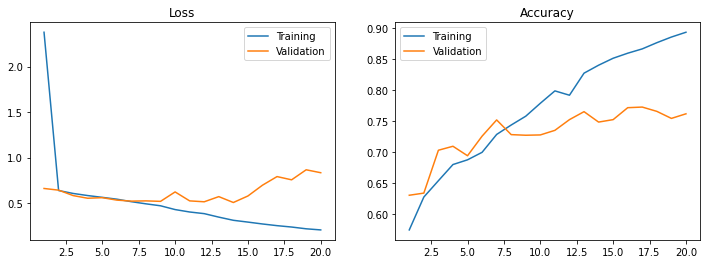

In [ ]:
# 손실함수, 정확도 그래프 그리기 
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 20)

### 5-2-4. 데이터 증강

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True,
                                   rotation_range=35,                                
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen_aug = image_gen_aug.flow_from_directory(train_dir, 
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,  
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/40
251/251 [==============================] - 122s 483ms/step - loss: 7.1604 - accuracy: 0.5467 - val_loss: 0.6631 - val_accuracy: 0.6253
Epoch 2/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6294 - accuracy: 0.6413 - val_loss: 0.6335 - val_accuracy: 0.6792
Epoch 3/40
251/251 [==============================] - 121s 483ms/step - loss: 0.6135 - accuracy: 0.6586 - val_loss: 0.6064 - val_accuracy: 0.6599
Epoch 4/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6060 - accuracy: 0.6558 - val_loss: 0.5441 - val_accuracy: 0.7266
Epoch 5/40
251/251 [==============================] - 121s 483ms/step - loss: 0.5933 - accuracy: 0.6678 - val_loss: 0.5804 - val_accuracy: 0.6950
Epoch 6/40
251/251 [==============================] - 121s 482ms/step - loss: 0.5876 - accuracy: 0.6787 - val_loss: 0.5673 - val_accuracy: 0.7064
Epoch 7/40
251/251 [====================

- 손실함수와 모델의 정확도 그래프를 보면, 과대적합 or 과소적합이 거의 발생하지 않고 학습이 잘 진행되는 것이 확인됨

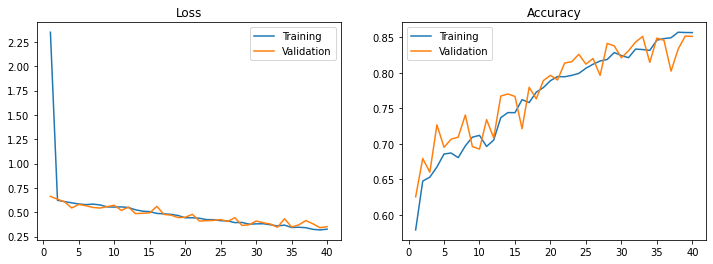

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(history_aug, 40)